In [1]:
import math
import tensorflow as tf
import numba as nb
from numba import njit, prange
import numpy as np
from numpy.random import rand

In [88]:
@njit(cache=True, parallel=True)
def mult(a, b, res):
    n = len(a)
    m = len(b)
    for i in prange(n):
        for j in range(m):
            res[i,j] = a[i]*b[j]

class Sigmoid:
    def calc(self, X):
        self.sigmoid = 1.0/(1.0+np.exp(-X))
        return self.sigmoid[:] # return copy
    def grad(self, vec_top_grad):
        return vec_top_grad*self.sigmoid*(1.0-self.sigmoid)

class LeakyReLU:
    def __init__(self):
        self.alpha = 0.1
    def calc(self, X):
        self.LeakyReLU = np.where(X>0,X, self.alpha*X)
        return self.LeakyReLU[:] # return copy
    def grad(self, vec_top_grad):
        return vec_top_grad*np.where(self.LeakyReLU>0, 1.0, self.alpha)
    
def initW(n_input, n_output): # Xavier init
    tmp1 = np.random.normal(0.0, 2.0/(n_input+n_output), size=n_input*n_output)
    tmp1 = tmp1.reshape(n_input,n_output).astype('float32')
    tmp2 = np.random.normal(0.0, 2.0/(n_output+n_output), size=n_output).astype('float32')
    return tmp1, tmp2

In [86]:
class CrossEntropy:
    def __init__(self, num_classes, batch = 1, eps = 1e-6):
        self.num_classes = num_classes
        self.drop_grad = np.zeros(self.num_classes, dtype='float32')
        self.batch = batch
        self.eps = eps
    def calc(self, X, label):
        self.X = X[:] # copy
        self.X[label] = X[label].clip(min=self.eps, max=1.0)
        return -np.log(self.X[label])
    def grad(self, label):
        self.drop_grad.fill(0.0)
        self.drop_grad[label] = -1.0/self.X[label]
        return self.drop_grad[:] # return copy
    
class SoftMax:
    def __init__(self, n):
        self.n = n
        self.tmp = np.empty((n,n), dtype='float32')
        self.softmax = np.empty(n, dtype='float32')
    def calc(self, X):
        #print('x in softmax', max(X))
        self.softmax = np.exp(X)
        self.softmax /= np.sum(self.softmax)
        return self.softmax
    def grad(self, vec_top_grad):
        mult(-self.softmax, self.softmax, self.tmp)
        self.tmp[np.diag_indices_from(self.tmp)] += self.softmax#*(1.0-self.softmax)
        return np.dot(vec_top_grad, self.tmp)

class Net:
    const_coeff = 0.1
    coeff = 0.1
    def __init__(self, layers, num_classes):
        self.layers = layers
        self.n_layers = len(layers)
        self.cross = CrossEntropy(num_classes)
    def calc(self, x):
        res = None
        for layer in self.layers:
            res = layer.calc(x)
            #print(res)
            x = res
        return res
    def get_class(self, x):
        res = self.calc(x)
        return np.argmax(res), res
    def fit(self, X, Y, n):
        Net.coeff = Net.const_coeff
        loss = np.zeros(shape=(n, len(Y)), dtype='float32')
        for it in range(n):
            print('EPOCH',it+1)
            for x,y,i in zip(X,Y,range(len(Y))):
                res = self.calc(x)
                # cross res
                loss[it, i] = self.cross.calc(res, y)
                gr = self.cross.grad(y)
                for layer in reversed(self.layers):
                    gr = layer.grad(gr)
            Net.coeff *= 0.90
        return loss.flatten()
                

In [4]:
class FullConnected:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.n_input = len(W)
        self.n_output = len(b)
        self.new_grad = np.zeros((self.n_input,self.n_output), dtype='float32')
        self.res = np.zeros(self.n_output, dtype='float32')
    def calc(self, x):
        self.x = x[:] # copy
        #vec(x)*matr(W)=vec(y)
        self.res = np.dot(x, self.W)
        self.res += self.b
        #print('max W, b, res',np.max(self.W), np.max(self.b), np.max(self.res))
        return self.res
    def grad(self, vec_top_grad):
        # поиск производной выхода y по входу x: d(y)/d(x)
        next_grad = np.dot(self.W, vec_top_grad) #порядок умножения?
        
        # поиск производной по W
        mult(self.x, vec_top_grad, self.new_grad)
        self.W -= Net.coeff*self.new_grad #Net.coef коэффициент градиентного спуска
        
        # поиск производной по b
        self.b -= Net.coeff*vec_top_grad
        return next_grad

In [5]:
num_classes = 4
cross = CrossEntropy(num_classes)

x = np.array([1.,0.5], dtype='float32')
label = 1
np.random.seed(0)
l1 = FullConnected(*initW(2,4))
l2 = FullConnected(*initW(4,num_classes))
softmax = SoftMax(num_classes)

net = Net([l1,l2, softmax],num_classes)
net.fit([x], [label], 10)
res = net.calc(x)
print(res)
cross.calc(res, label)

EPOCH 1
x in softmax 0.86027646
EPOCH 2
x in softmax 0.83313596
EPOCH 3
x in softmax 0.8066898
EPOCH 4
x in softmax 0.7809069
EPOCH 5
x in softmax 0.7557584
EPOCH 6
x in softmax 0.7312168
EPOCH 7
x in softmax 0.70725584
EPOCH 8
x in softmax 0.68385094
EPOCH 9
x in softmax 0.6609789
EPOCH 10
x in softmax 0.63861763
x in softmax 0.6167463
[0.33774284 0.26497394 0.22456934 0.17271389]


1.3281238

In [6]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle('data/data_batch_1')

In [84]:
from PIL import Image
print(data.keys())
start, end = 2, 23
img_ars = data[b'data'][start:end]
img_labels = data[b'labels'][start:end]
print(len(data[b'labels']))
print(len(img_ars[0]))
print(type(img_ars[0]))
img_ars = img_ars
for img_ar,i in zip(img_ars, range(start,end)):
    img = Image.fromarray(np.transpose(np.reshape(img_ar,(3, 32,32)), (1,2,0)), 'RGB')
    #img.save(str(i)+'.png')
#print(img_labels)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
10000
3072
<class 'numpy.ndarray'>


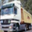

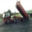

In [32]:
import matplotlib.pyplot as plt

EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
0.17223848


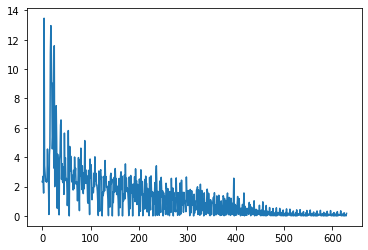

In [91]:
num_classes = 10
n_input = len(img_ars[0])

cross = CrossEntropy(num_classes)
x = (img_ars/255.0).astype('float32')
labels = img_labels
#print(labels)
np.random.seed(0)
l1 = FullConnected(*initW(n_input, 192))
leakyReLU = LeakyReLU()
l2 = FullConnected(*initW(192, num_classes))
softmax = SoftMax(num_classes)

net = Net([l1, leakyReLU, l2, softmax],num_classes)
loss = net.fit(x, labels, 30)
print(loss[-1])
plt.plot(loss)
#for vl in range(len(x)):
#    calc_class, res = net.get_class(x[vl])
#    print(labels[vl], calc_class)
    #print(res)